# L-Layer Neural Network for Regression (from scratch)
Throughout several projects, I realized that multilayer Neural Networks usually outperform multiple regression models (including polynomial regressions), when predicting continuous response variables, as long as there are enough observations in the training set.  
Therefore, I present, here, the step-by-step development of an L-Layer Neural Network with continuous response variable that can be used for regression problems. 

I used some of the code chunks provided by the deep learning specialization "Neural Networks and Deep Learning" from deeplearning.io on Coursera. 

Note that the data generation process, model training, and evaluation procedures are only presented for completeness and illustration purpose. This manuscript does neither focus on the quality of the fit/prediction, nor on hyperparameter tuning. 

In [1]:
#required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Generate Test Data
Simulation of data from an 'abitrary' non-linear model:
$$y = w_0+X_0w_1+X_1^{w2}+X_2^2w_3X_3w_4+X_4w_5+\epsilon,$$
where $w$ is a $6$-by-$1$ weight vector, $X$ is a $5$-by-$m$ feature matrix, and $\epsilon$ is the error $\sim NV(0,1)$. $m$ denotes the number of examples. 

In [2]:
#size of sample
m = 10000 

#feature matrix
X = np.transpose(np.random.rand(m, 5)) 


# create response vector  w0+X0+w1+X1^w2+X2^2*w3*X3*w4+X4*w5
w = np.array([1,10,2,4,3,10]) #weights
y = w[0]+X[0]*w[1]+X[1]**w[2]+(X[2]**2)*w[3]*X[3]*w[4]+X[4]*w[5]+np.random.randn(m) 
y = y.reshape(1,len(y))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

print("Dimension feature vector X:", X.shape)
print("Dimension response vector y:", y.shape)

Dimension feature vector X: (5, 10000)
Dimension response vector y: (1, 10000)


## Training & Testset
In order to evaluate the method, the data is split into Training and Test set. The NN is trained with the Training set and the evaluation is done with the Test set. Note that for real-world applications, there should also be included a Dev Set and the set sizes should depend on the sample size.

In [3]:
fraction = 0.95
train_X = X.sample(frac=fraction, axis=1)
test_X=X.drop(train_X.columns, axis=1)
train_y = y.iloc[:,train_X.columns]
test_y = y.drop(train_X.columns, axis=1)

print("train_X", train_X.shape)
print("train_y", train_y.shape)
print("test_X", test_X.shape)
print("test_y", test_y.shape)

train_X (5, 9500)
train_y (1, 9500)
test_X (5, 500)
test_y (1, 500)


## Forward Propagation
Conceptually, in forward propagation, first an input feature vector is multiplied with a weight matrix and a bias vector is added. Then, in order to achieve non-linearity, the weighted sum is fed into an activation function. This provides the output of the jth unit of layer $[l]$. Multiplications are simultaneously performed by multiple units of layer [l] providing an output vector of length equal to the number of units. This output vector is then multiplied by the weight matrix of the subsequent layer [l+1] and fed into the activation function of layer [l+1]. After repeating this process L-1 times (for an L-Layer NN), the output vector (at layer L-1) is fed into a final activation function, which is for classification problems usually a sigmoid function. This provides a single output value between 0 and 1 considered the predicted label of the NN. However, here, we used an identity function to obtain a real-numbered continuous outcome. 

Finally, this process can be simultaneously performed with multiple training examples. The output of multiple training examples (the number depends on the batch size) is fed into a cost function (this usually coincides with the Maximum Likelihood Estimator) which computes the "difference" between the output and the observed label, considered the Cost. 

### Initialize Parameters
The forward propagation initiates with a weight matrix $W^{[l]}$ with relatively small and randomly chosen values and bias $b^{[l]}$ set to 0.

$W^{[l]}$ is a $n^{[l]}$-by-$n^{[l-1]}$ weight matrix and 

$b^{[l]}$ is a $n^{[l]}$-by-$1$ bias vector. 

$[l]$ denotes layer $l$ and $n^{[l]}$ is the number of nodes/units in layer $[l]$.


In [4]:
def initialize_parameters_deep(layer_dims):
    
    #np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers
    
    #Initialize randomly parameters for L layers
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

### Activation functions
For illustration purpose, it is here used the nonlinear Relu Activation function for all units of layers [l], l<L:

$f(Z) = max(0,Z).$ 

Its derivative $\frac{df(Z)}{dZ} = 1$, $\forall~Z > 0$, otherwise $Z = 0$. 

In [5]:
#forward nonlinear activation function
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    return A, cache

#backward (derivative of nonlinear activation function)
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)  
    dZ[Z <= 0] = 0
    return dZ

### Linear Forward Propagation Steps
1) **Linear Forward Functions**

<span style="color:blue"> linear_forward</span>: 
$$Z^{[l]}=W^{[l]}A^{[l-1]}+b^{[l]},$$

$Z^{[l]}$ is a $n^{[l]}$-by-$m$ matrix of linear output,  

$m$ is the number of samples,  

$A^{[l-1]}$ is a $n^{[l-1]}$-by-$m$ input matrix (feature or output of previous layer),

$W^{[l]}$ is a $n^{[l]}$-by-$n^{[l-1]}$ weight matrix and 

$b^{[l]}$ is a $n^{[l]}$-by-$1$ bias vector. 


2) **Activation Function**

<span style="color:blue">linear_activation_forward</span>: 

If activation = ''Output'': $Z^{[l]} = A^{[l]}$ (identity activation function).

If activation = ''Relu'', the ReLu activation function is applied to $Z^{[l]}: g(Z^{[l]}) = A^{[l]}$, this manner introducing non-linearity. (Where $g(~)$ is the ReLu activation function.)  


3) **Join Step 1 and Step 2**

<span style="color:blue">L_model_forward</span>: 

The linear_forward + linear_activation_forward (with Relu activation function) are repeated L-1 times (for L-1 layers).

At the last layer $L, Z^{[L]} = A^{[L]}$, which is the final output ($A^{[L]} = Y_{hat}$). 

In [6]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "Output":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = Z,Z
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    cache = (linear_cache, activation_cache)
    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers 
    
    # Implement [LINEAR -> RELU]*(L-1). 
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR. 
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "Output")
    caches.append(cache)
    
    return AL, caches

## Cost Function
The cost function measures how well the parameters perform on the training set. 
For a linear regression (at layer L) it minimizes the sum of least squares, called Ordinary Least Squares method (OLS). 
$\mathcal L(a,y) = \frac{1}{m}\sum_{i=1}^m(a_i-y_i)^2$

In [7]:
def compute_cost(AL, Y):
    # Compute cost from yhat=AL and y.
    cost = (1./Y.shape[1]) * (np.sum((np.array(AL)-np.array(Y))**2))
    cost = np.squeeze(cost)      # turns [[value]] into value).
    
    return cost

## Backward Propagation

The back-propagation computes the derivative (called gradient since there are multiple dimensions) of the cost/loss function with respect to the weights. The gradients are computed successively/iteratively starting at the final Layer L. The algorithm that I used here for learning the model parameters is called Gradient Descent. 

The backpropagation steps are:

1) **Identity backwards**:

Since the output is a real number obtained from the linear combination of input (from previous layers) and weights of layer L, the gradient is obtained by derivating the cost function (OLS):

$dA^{[L]} = \frac{d\mathcal L(A,Y)}{dA^{[L]}} = 2(A^{[L]}-Y)$.

Because $Z^{[L]} = A^{[L]}$, -> $dZ^{[L]} = dA^{[L]} = 1$. 

Note that for simplicity, $\frac{d\mathcal L(A,Y)}{dA^{[l-1]}}$ is written as $dA^{[l-1]}$,  $\frac{d\mathcal L(A,Y)}{dZ^{[l]}}$ as $dZ^{[l]}$, etc.

$A^{[L]}, dA^{[L]}, Z^{[L]}, dZ^{[L]}$ are $1$-by-$m$ vectors.



2) **Linear backward**:

Subsequently, the gradients are computed by propagating backwards along the layers, using the caches (values from the forward propagation) and the gradients from the previous (later) layers. 

<span style="color:blue">linear_backward</span>: 
$$dA^{[l-1]} = W^{[l]T}dZ^{[l]},\\
dW^{[l]} = \frac{1}{m}dZ^{[l]}A^{[l-1]T},\\
db^{[l]} = \frac{1}{m}\sum_{i=1}^mdZ^{[l](i)},\\
l = L,\ldots,1.\\$$



$dZ^{[l]}$ is a $n^{[l]}$-by-$m$ matrix,  

$A^{[l-1]}$ and $dA^{[l-1]}$ are $n^{[l-1]}$-by-$m$ matrices,

$dW^{[l]}$ is a $n^{[l]}$-by-$n^{[l-1]}$ matrix,

$db^{[l]}$ is a $n^{[l]}$-by-$1$ vector. 

3) **Derivative of ReLu activation function**:

In order to obtain $dZ^{[l]}, \forall l<L$, $Z$ is fed into $g'(~)$, which is the first derivative of the ReLu activation function, multiplied by $dA^{[l]}$, obtained from the previous layer.

<span style="color:blue">linear_activation_backward</span>: 
$$dZ^{[l]} = dA^{[l]}g'(Z^{[l]}),$$


where $g'(Z) = 1, \forall~Z > 0$, otherwise $Z = 0$, for all layers $l<L$.






**Put altogether **


<span style="color:blue">L_model_backward</span>: 

This function joins all three steps.

1) $dZ^{[L]} = dA^{[L]}$ is obtained.

2) The linear_backward function computes $A^{[l-1]}$, $dW^{[l]}$, and $db^{[l]}$.

3) The linear_activation_backward function computes dZ^{[l]}. 

Step two and three are repeated L-1 times (for L-1 layers). 







In [8]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "Output":
        dZ = dA
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = np.array(Y)
    Y = Y.reshape(AL.shape) #shape Y as AL
    
    # Initializing the backpropagation
    dAL = 2*(np.array(AL)-np.array(Y))
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "Output")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## Update Parameters
The parameters (weights and biases) are updated at each iteration by using gradient descent. 
$$W^{[l]} =  W^{[l]} - \alpha~dW^{[l]},\\
b^{[l]} =  b^{[l]} - \alpha~db^{[l]},$$
where $\alpha$ denotes the learning rate reflecting the size of the step down the gradient (i.e., multidimensional slope).

In [9]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

## Predict
After the last parameter update (of backpropagation), the parameters  are used in a final forward propagation step using the feature matrix $X$ of the test set in order to predict $Y$ of the test set. 

In [10]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Final Forward propagation
    hat, caches = L_model_forward(X, parameters)

    #Mean Squared Error
    MSE = 1./m * np.sum((hat - y)**2) 
    #print("MSE:", MSE ) 
        
    return hat 

## L-Layer Neural Net
All functions are combined within a single function (i.e., the L-Layer Neural Net Model)

In [11]:
#L Layer Neural Net
def L_layer_model(X, Y, layers_dims, learning_rate, iterations, print_cost=False):
    costs = [] # track costs
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    #iterate forward and backward propagation "iterations" times
    for i in range(0, iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> Output(L) (LINEAR)
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Training
Now, the model has to be trained with the training data (i.e., multiple forward and backward propagations). The batch size equals, here, the size of the entire training set. Outcomes are compouted (forward propagation) and the parameters updated (backward propagation) for 2500 times.
For illustration purpose only, we used here an 4-Layer Neural Network ($n_x=5, n_1=7, n_2=5, n_3=4, n_y=1$) 

Cost after iteration 0: 195.779207
Cost after iteration 100: 157.026971
Cost after iteration 200: 41.754068
Cost after iteration 300: 14.382812
Cost after iteration 400: 13.013562
Cost after iteration 500: 11.792586
Cost after iteration 600: 10.678977
Cost after iteration 700: 9.691299
Cost after iteration 800: 8.808180
Cost after iteration 900: 8.009290
Cost after iteration 1000: 7.285844
Cost after iteration 1100: 6.635167


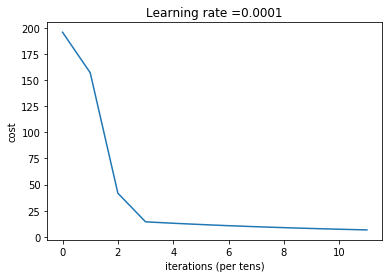

In [20]:
n_x = X.shape[0]   
n_y = y.shape[0]
layers_dims = (n_x, 7,5,4, n_y) #define here the number and size of the layers
parameters = L_layer_model(train_X, train_y, layers_dims = layers_dims, learning_rate=0.0001, iterations = 1200, print_cost = True)

## Prediction and Evaluation 
The model was training with the Training Set and, subsequently, we use the Test Set in order to evaluate the model. The fit is evaluated by the Mean Squared Error (MSE). $y_{hat}$ is the predicted outcome of the model and $y$ a true observation of the test sample. 

In [21]:
#Predictions of test set
predictions_train = predict(train_X, train_y, parameters)
predictions_test = predict(test_X, test_y, parameters)

#difference between prediction and true test value
dif = np.array(test_y)[0,:] - np.array(predictions_test)[0,:]

m = len(np.array(test_y)[0,:])
MSE_train = 1/m*np.sum((np.array(train_y)[0,:] - np.array(predictions_train)[0,:])**2)
MSE_test = 1/m*np.sum((np.array(test_y)[0,:] - np.array(predictions_test)[0,:])**2)

print("Mean Squared Error Training:", MSE_train)
print("Mean Squared Error Test:", MSE_test)

Mean Squared Error Training: 115.009451494
Mean Squared Error Test: 6.05337907228


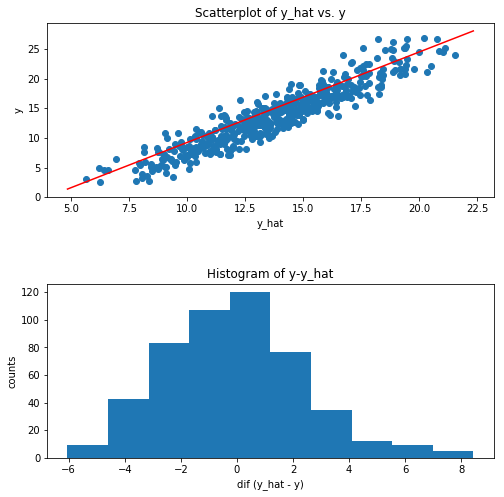

In [22]:
t = np.arange(0,test_y.shape[1],1)
f, (ax1, ax2) = plt.subplots(2, 1, sharey=False, figsize=(8, 8))
ax1.scatter(np.array(predictions_test)[0,:],  np.array(test_y)[0,:], label="y")
ax1.set_title('Scatterplot of y_hat vs. y')
ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="-", color="red")
ax1.set_xlabel('y_hat')
ax1.set_ylabel('y')

ax2.hist(dif)
ax2.set_title('Histogram of y-y_hat')
ax2.set_xlabel('dif (y_hat - y)')
ax2.set_ylabel('counts')
plt.subplots_adjust(hspace = 0.5)
plt.show(1,1)

When falling on the red line (top) and when being 0 (bottom), the predictions coincide with the true values